In [39]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import cmocean.cm as cmo
from matplotlib import rc
from miracca_functions import psi2uv, zeta, zeta2psi
from lietal import *
import windspharm 
from scipy.stats import pearsonr
from scipy.interpolate import interp1d, griddata
import warnings
warnings.filterwarnings('ignore')

## We will perform the Helmholtz decomposition using the windspharm package and HYCOM velocity outputs

### Loading the outputs and extracting variables

In [40]:
path = '/media/marianalage/Peanut/Paper_Rossby/'
HYCOM = nc.Dataset(path+'HYCOM_teste_psi_53X.nc4')
HYCOM.variables.keys()

dict_keys(['surf_el', 'time', 'lat', 'lon', 'water_u_bottom', 'water_v_bottom', 'water_u', 'depth', 'water_v'])

In [41]:
lat = HYCOM.variables['lat'][:].data
lon = HYCOM.variables['lon'][:].data

u = HYCOM.variables['water_u'][:].data.squeeze()
u = u[0,:,:] #surface
v = HYCOM.variables['water_v'][:].data.squeeze()
v = v[0,:,:] #surface

ssh = HYCOM.variables['surf_el'][:].data.squeeze()

Calculating the geostrophic $\psi$, derived from HYCOM's SSH:

In [42]:
# Geostrophic Psi and velocities 
om = (2*np.pi)/(24*60*60)
f0 = (2.*om*np.sin(lat.mean()*(np.pi/180.)))

Psi_ssh = ssh*9.8/f0

ln,lt = np.meshgrid(lon,lat)
u_g,v_g = psi2uv(ln,lt,Psi_ssh)

Plotting $\psi$ and velocities:

Text(0.5, 1.0, '$\\psi \\times 10^{-5} m^2/s$')

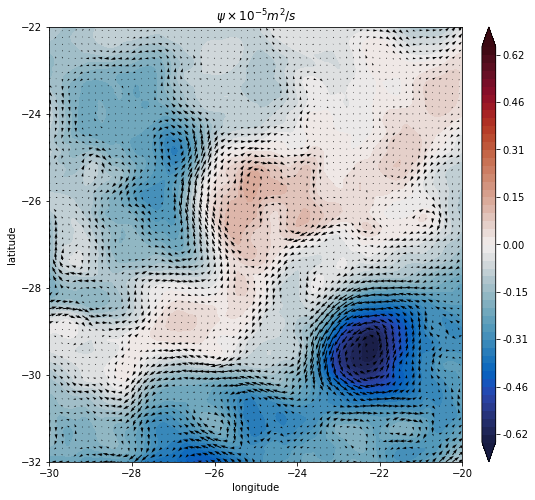

In [43]:
vmin = np.min(Psi_ssh*1e-5)
vmax = -vmin
levels = np.linspace(vmin,vmax,51)
cmap=cmo.balance

step=2

grd = gs.GridSpec(25,27)
fig1 = plt.figure(figsize=(8,8))

ax1 = fig1.add_subplot(grd[:,:25])
ax2 = fig1.add_subplot(grd[:,26:])
cf = ax1.contourf(ln,lt,Psi_ssh*1e-5,vmin=vmin,
                  vmax=vmax,levels=levels,cmap=cmap,extend='both')
cbar = plt.colorbar(cf,cax=ax2,format='%.2f')
ax1.quiver(ln[::step,::step],lt[::step,::step],
           u_g[::step,::step],v_g[::step,::step],color='k',lw=2)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_title(r'$\psi \times 10^{-5} m^2/s$')


### Windspharm requires the fields to be lat x lon x other dimensions, so uncomment the following lines if your data is other than lat x lon x dim


In [44]:
#u, info = windspharm.tools.prep_data(u, 'xy')
#v, _ = windspharm.tools.prep_data(v, 'xy')

### Windspharm also requires that latitude is north-to-south instead of south-to-north oriented. And you may change your variables as well

In [45]:
lat, u, v = windspharm.tools.order_latdim(lat, u, v)

ln,lt = np.meshgrid(lon,lat)

In [46]:
V = windspharm.standard.VectorWind(u, v) # it is already a regular grid

In [83]:
# Obtaining the variables of interest
# Helmholtz decomposition

wpsi, wphi = V.sfvp()
uchi, vchi, upsi, vpsi = V.helmholtz()

### And voilà!

Plotting the geostrophic $\psi_g$ (non-divergent) and the velocities:

Text(0.5, 1.0, '$\\psi_g \\times 10^{-5} m^2/s$')

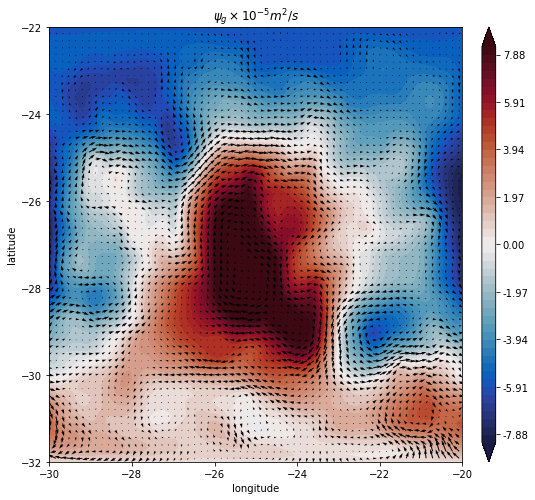

In [48]:
step=2
vmin = np.min(wpsi*1e-5)
vmax = -vmin
levels = np.linspace(vmin,vmax,51)
cmap=cmo.balance

grd = gs.GridSpec(25,27)
fig1 = plt.figure(figsize=(8,8))

ax1 = fig1.add_subplot(grd[:,:25])
ax2 = fig1.add_subplot(grd[:,26:])
cf = ax1.contourf(lon,lat,wpsi*1e-5,vmin=vmin,
                  vmax=vmax,levels=levels,cmap=cmap,extend='both')
cbar = plt.colorbar(cf,cax=ax2,format='%.2f')
ax1.quiver(ln[::step,::step],lt[::step,::step],
           upsi[::step,::step],vpsi[::step,::step],color='k',lw=2)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_title(r'$\psi_g \times 10^{-5} m^2/s$')

Plotting the $\phi$ (non-rotational) and the velocities:

Text(0.5, 1.0, '$\\phi \\times 10^{-5}$')

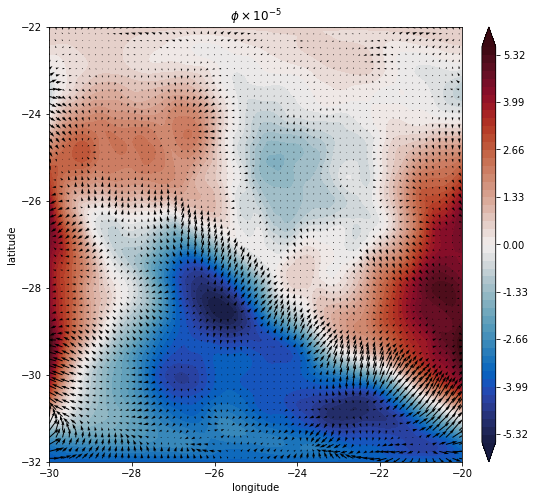

In [52]:
vmin = np.min(wphi*1e-5)
vmax = -vmin
levels = np.linspace(vmin,vmax,51)

grd = gs.GridSpec(25,27)
fig1 = plt.figure(figsize=(8,8))

ax1 = fig1.add_subplot(grd[:,:25])
ax2 = fig1.add_subplot(grd[:,26:])
cf = ax1.contourf(lon,lat,wphi*1e-5,vmin=vmin,
                  vmax=vmax,levels=levels,cmap=cmap,extend='both')
cbar = plt.colorbar(cf,cax=ax2,format='%.2f')
ax1.quiver(ln[::step,::step],lt[::step,::step],
           uchi[::step,::step],vchi[::step,::step],color='k',lw=2)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_title(r'$\phi \times 10^{-5}$')

Let's compare the velocities! 


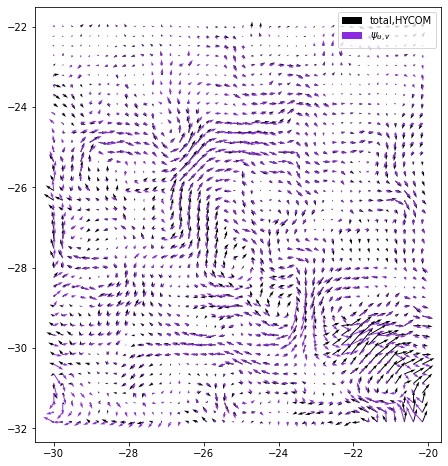

In [61]:
step = 3

grd = gs.GridSpec(20,22)
fig1 = plt.figure(figsize=(8,8))

ax1 = fig1.add_subplot(grd[:,:20])
ax1.quiver(ln[::step,::step],lt[::step,::step],
           u[::step,::step],v[::step,::step],
           color='k',lw=2,label='total,HYCOM')
ax1.quiver(ln[::step,::step],lt[::step,::step],
           upsi[::step,::step],vpsi[::step,::step],
           color='#8A2BE2',lw=2,label=r'$\psi_{u,v}$')
#ax1.quiver(ln[::step,::step],lt[::step,::step],
#           uchi[::step,::step],vchi[::step,::step],
#           color='#DC143C',lw=2,label=r'$\phi_{u,v}$')
ax1.legend(loc=0)

# Spatial correlations between $\Psi_{ssh}$ and $\Psi_g$

In [82]:
print('Corr = {:.2f}'.format(pearsonr(Psi_ssh.ravel(),wpsi.ravel())[0]),
      ', p-value = {:.2f}'.format(pearsonr(Psi_ssh.ravel(),wpsi.ravel())[1]) )

Corr = 0.50 , p-value = 0.00


Now the velocities...


In [80]:
print('Corr u = {:.2f}'.format(pearsonr(u.ravel(),upsi.ravel())[0]),
      ', p-value = {:.2f}'.format(pearsonr(u.ravel(),upsi.ravel())[1]) )

Corr u = 0.84 , p-value = 0.00


In [81]:
print('Corr v = {:.2f}'.format(pearsonr(v.ravel(),vpsi.ravel())[0]),
      ', p-value = {:.2f}'.format(pearsonr(u.ravel(),upsi.ravel())[1]) )

Corr v = 0.80 , p-value = 0.00
